# An example of using multi-imbalance
In this tutorial we will show how to increase results for multi class imbalanced datasets significantly.
The practical classification problem will serve as an example.

We will perform the processing of the glass dataset.
Glass is a real-life dataset containing information about the purpose of glass, e.g. for windows or headlights in cars.
In the dataset, there are 7 types of glass usages so our problem is multi class.
We will predict the class based on 214 examples with 9 attributes representing the content of individual elements such as Aluminum or Magnesium in the tested sample.

In [1]:
import os
import numpy as np

seed = 12
np.random.seed(seed)

%matplotlib inline

dataset_name = 'glass'
dir=os.getcwd() # te sciezkie potem poprawie

### Data loading

We begin with loading the data - it can be performed using the library's util for loading arff type files. The util loads arff files and performs onehotencoding for discrete variables.
The features will be ordered with all the continuous features first, followed by the ones modified by one hot encoder.

In [2]:
from multi_imbalance.utils.data import preprocess_dataset

X,y=preprocess_dataset(f'{dir}/../data/arff/{dataset_name}.arff')

print(X[:5])
print(y[:5])

[[ 1.51793 12.79     3.5      1.12    73.03     0.64     8.77     0.
   0.     ]
 [ 1.51643 12.16     3.52     1.35    72.89     0.57     8.53     0.
   0.     ]
 [ 1.51793 13.21     3.48     1.41    72.64     0.59     8.43     0.
   0.     ]
 [ 1.51299 14.4      1.74     1.54    74.55     0.       7.59     0.
   0.     ]
 [ 1.53393 12.3      0.       1.      70.16     0.12    16.19     0.
   0.24   ]]
[0 5 0 4 1]


This dataset is characterized by multi-class imbalance. In order to visualize the imbalance and difficulty of the set,
we will use the function from multi-imbalance library, which shows the class sizes and the data in a reduced two-dimensional space.

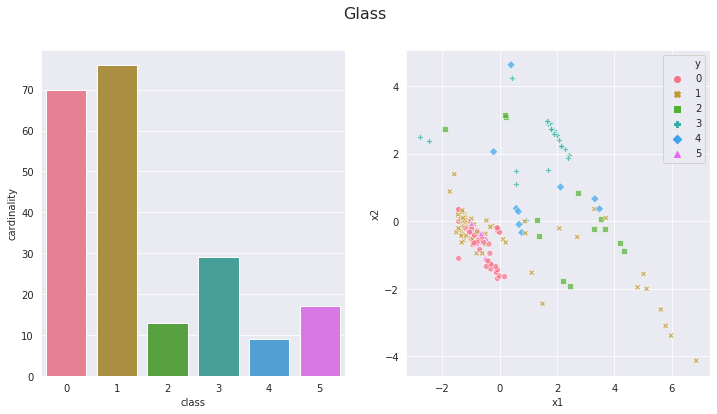

In [3]:
from multi_imbalance.utils.plot import plot_cardinality_and_2d_data
plot_cardinality_and_2d_data(X,y,'Glass')

As shown above, there is multi-class imbalance in the dataset.
There are 2 majority classes and 4 minority classes.

### Data preparation

In order to prepare data for training, we will split the data for train and test
subsets and normalize it. For both operations, we will use tools available in sklearn.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, stratify=y, random_state=seed)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Training

The training will be performed using a decision tree implementation from sklearn library.
Our library integrates seamlessly with other popular libraries, which enables use of all the benefits of the
python ecosystem.

In [5]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=seed)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

To evaluate predictions to multi-imbalanced class we apply generalized gmean of sensitives of each class:
$$ gmean = (\Pi_{i=1}^n sensitivity_i)^{\frac{1}{n}}$$

In [6]:
from multi_imbalance.utils.metrics import gmean_score

gmean = gmean_score(y_test, y_pred, correction=0.001)
f'Decision Tree: {round(gmean,3)}'

'Decision Tree: 0.222'

As we can see, the decision tree does not perform well for this type of problem. 

### Resampling
MDO (Mahalanobis Distance Oversampling) and SOUP (Similarity Oversampling Undersampling Preprocessing) are 
two more advanced preprocessing methods. As a first preprocessing we use MDO, which generates synthetic samples which 
have the same Mahalanobis distance from the considered class mean as other minority class examples.


In [7]:
from multi_imbalance.resampling.mdo import MDO

mdo = MDO(maj_int_min={
        'maj': [0, 1],
        'int': [],
        'min': [2, 3, 4, 5]
    })
X_train_res, y_train_res = mdo.fit_transform(X_train, y_train)


We will check how the cardinalities have changed using the function in our drawing util.

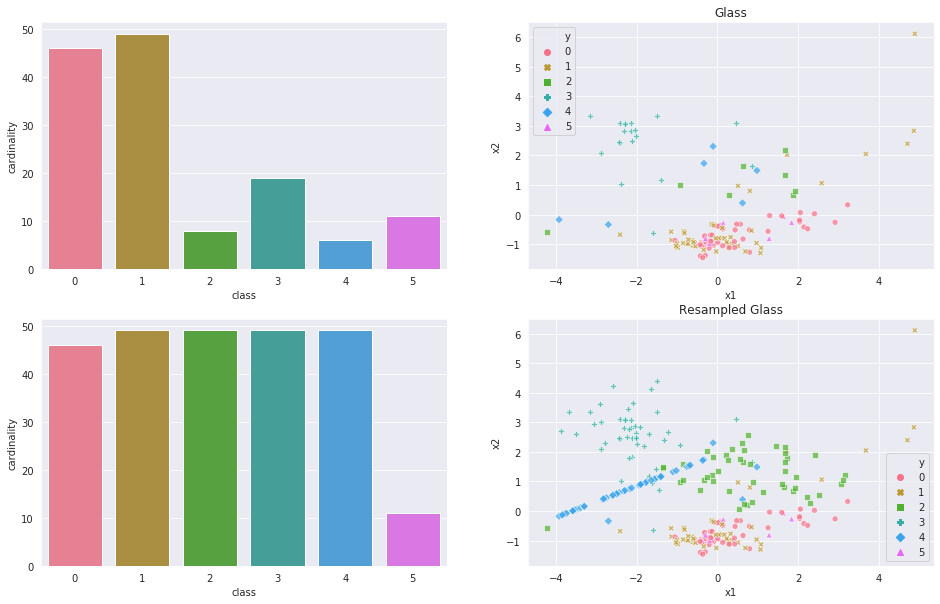

In [8]:
from multi_imbalance.utils.plot import plot_visual_comparision_datasets
plot_visual_comparision_datasets(X_train, y_train,X_train_res,y_train_res,'Glass','Resampled Glass')

The minority classes have been oversampled. Class 5 remains unchanged due to a lack of safe examples.

In [9]:
clf = DecisionTreeClassifier(random_state=seed)
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

gmean = gmean_score(y_test, y_pred, correction=0.001)
f'Decision Tree + MDO: {round(gmean,3)}'


'Decision Tree + MDO: 0.695'

SOUP is a recent hybrid data preprocessing method. It also handles complex inter-relations
between classes by means of their similarities and levels of difficulties
coefficients for examples belonging to each class.

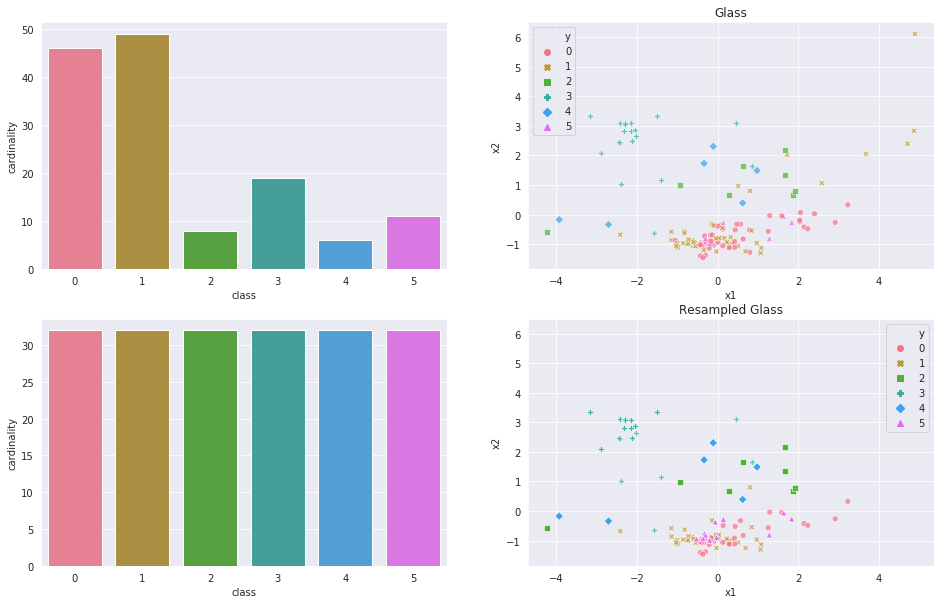

In [10]:
from multi_imbalance.resampling.soup import SOUP

soup = SOUP(maj_int_min={
        'maj': [0, 1],
        'int': [],
        'min': [2, 3, 4, 5]
    })
X_train_res, y_train_res = soup.fit_transform(X_train, y_train)
plot_visual_comparision_datasets(X_train, y_train,X_train_res,y_train_res,'Glass','Resampled Glass')

Class cardinalities have been equalized. Now, we perform the calculations once again with modified data.

In [11]:
clf = DecisionTreeClassifier(random_state=seed)
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

gmean = gmean_score(y_test, y_pred, correction=0.001)
f'Decision Tree + SOUP: {round(gmean,3)}'

'Decision Tree + SOUP: 0.743'

As one can notice, these specialized preprocessing methods improved Gmean evaluation measure.
In the library there are two types of methods implemented: preprocessing methods and ensemble methods.

### Ensemble
In this case, OVO (one class versus one class) implementation will be used. OVO is a data decomposition method,
where classes are paired in all possible configurations and the paires are used to train binary classifiers,
which votes are aggregated into the final decision. OVO implementation in our library allows the use of any
type of classifier with interface compatible with sklearn convention. The same applies for resampling methods.
Resampling is applied to pairs decomposed from the original data.
In this use case, SOUP will be used for resampling.

In [12]:
from multi_imbalance.ensemble.ovo import OVO

soup = SOUP(maj_int_min={
        'maj': [0, 1],
        'int': [],
        'min': [2, 3, 4, 5]
    })
clf = OVO(
    binary_classifier=DecisionTreeClassifier(random_state=seed),
    preprocessing=soup
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

gmean = gmean_score(y_test, y_pred, correction=0.001)
f'OVO with DecisionTree and SOUP: {round(gmean,3)}'

'OVO with DecisionTree and SOUP: 0.773'

As shown above, the OVO ensemble method along with SOUP resampling further improves the performance of the decision tree.

### Conclusions
In this guide we have shown that thanks to our library we can easily use methods dedicated for multi class imbalance
problems in real life datasets. During the entire tutorial,
we seamlessly integrated with popular libraries like sklearn and worked using well-known types like numpy arrays.
You can find more examples and descriptions of all methods in the documentation:
https://multi-imbalance.readthedocs.io/en/latest/
The source code is developed and available on github at: https://github.com/damian-horna/multi-imbalance